In [ ]:
!pip install seaborn
!pip install scikit-learn
!pip install ucimlrepo

Loading Heart Disease dataset...
Dataset shape: (303, 13)
Target shape: (303,)

Target distribution:
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Features:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

DATA PREPROCESSING
Missing values per feature:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64
Dataset shape after dropping NaN: (297, 13)

Binary target distribution:
0    160
1    137
Name: count, dtype: int64

Train set size: 237
Test set size: 60
Features standardized using StandardScaler

HYPERPARAMETER TUNING
C=  0.001, Penalty=l1: Test Accuracy = 0.5333
C=  0.010, Penalty=l1: Test Accuracy = 0.5333
C=  0.100, Penalty=l1: Test Accuracy = 0.8500
C=  1.000, Penalty=l1: Test Accuracy = 0.8333
C= 10.000, Penalty=l1: Test Accuracy = 0.8333
C=100.000

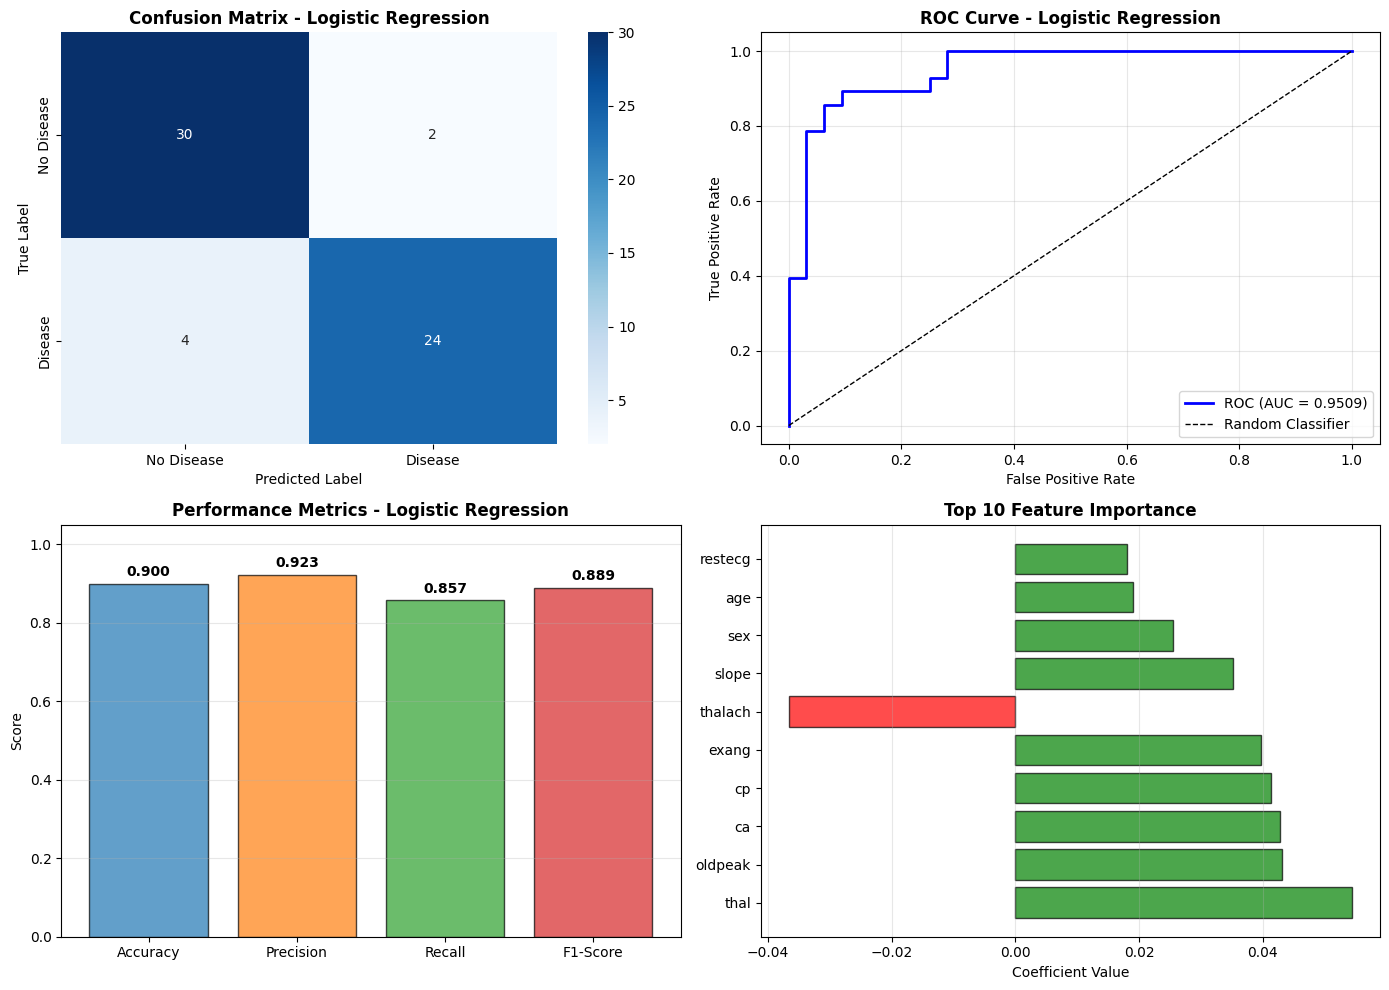

Feature correlation heatmap saved as 'feature_correlation_heatmap.png'


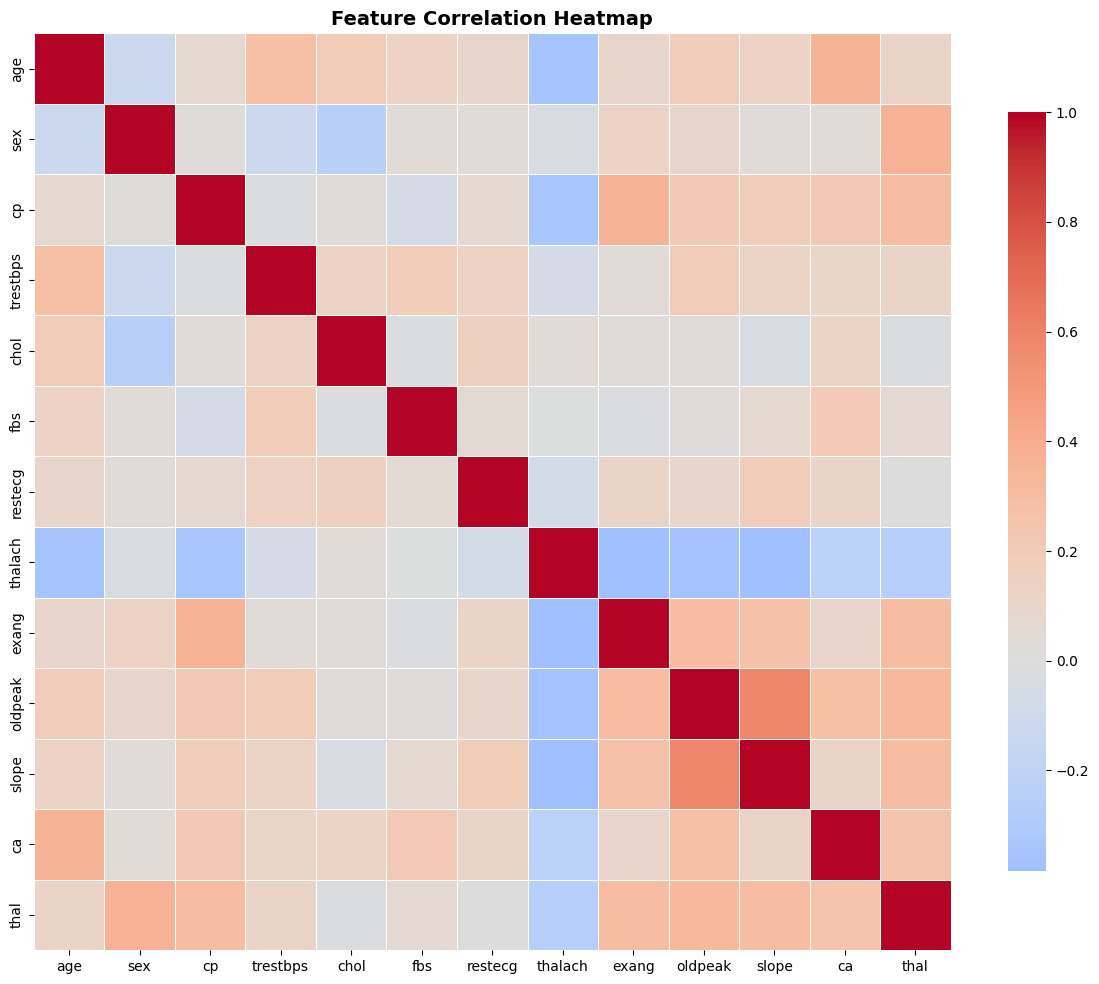

Feature distributions saved as 'feature_distributions.png'


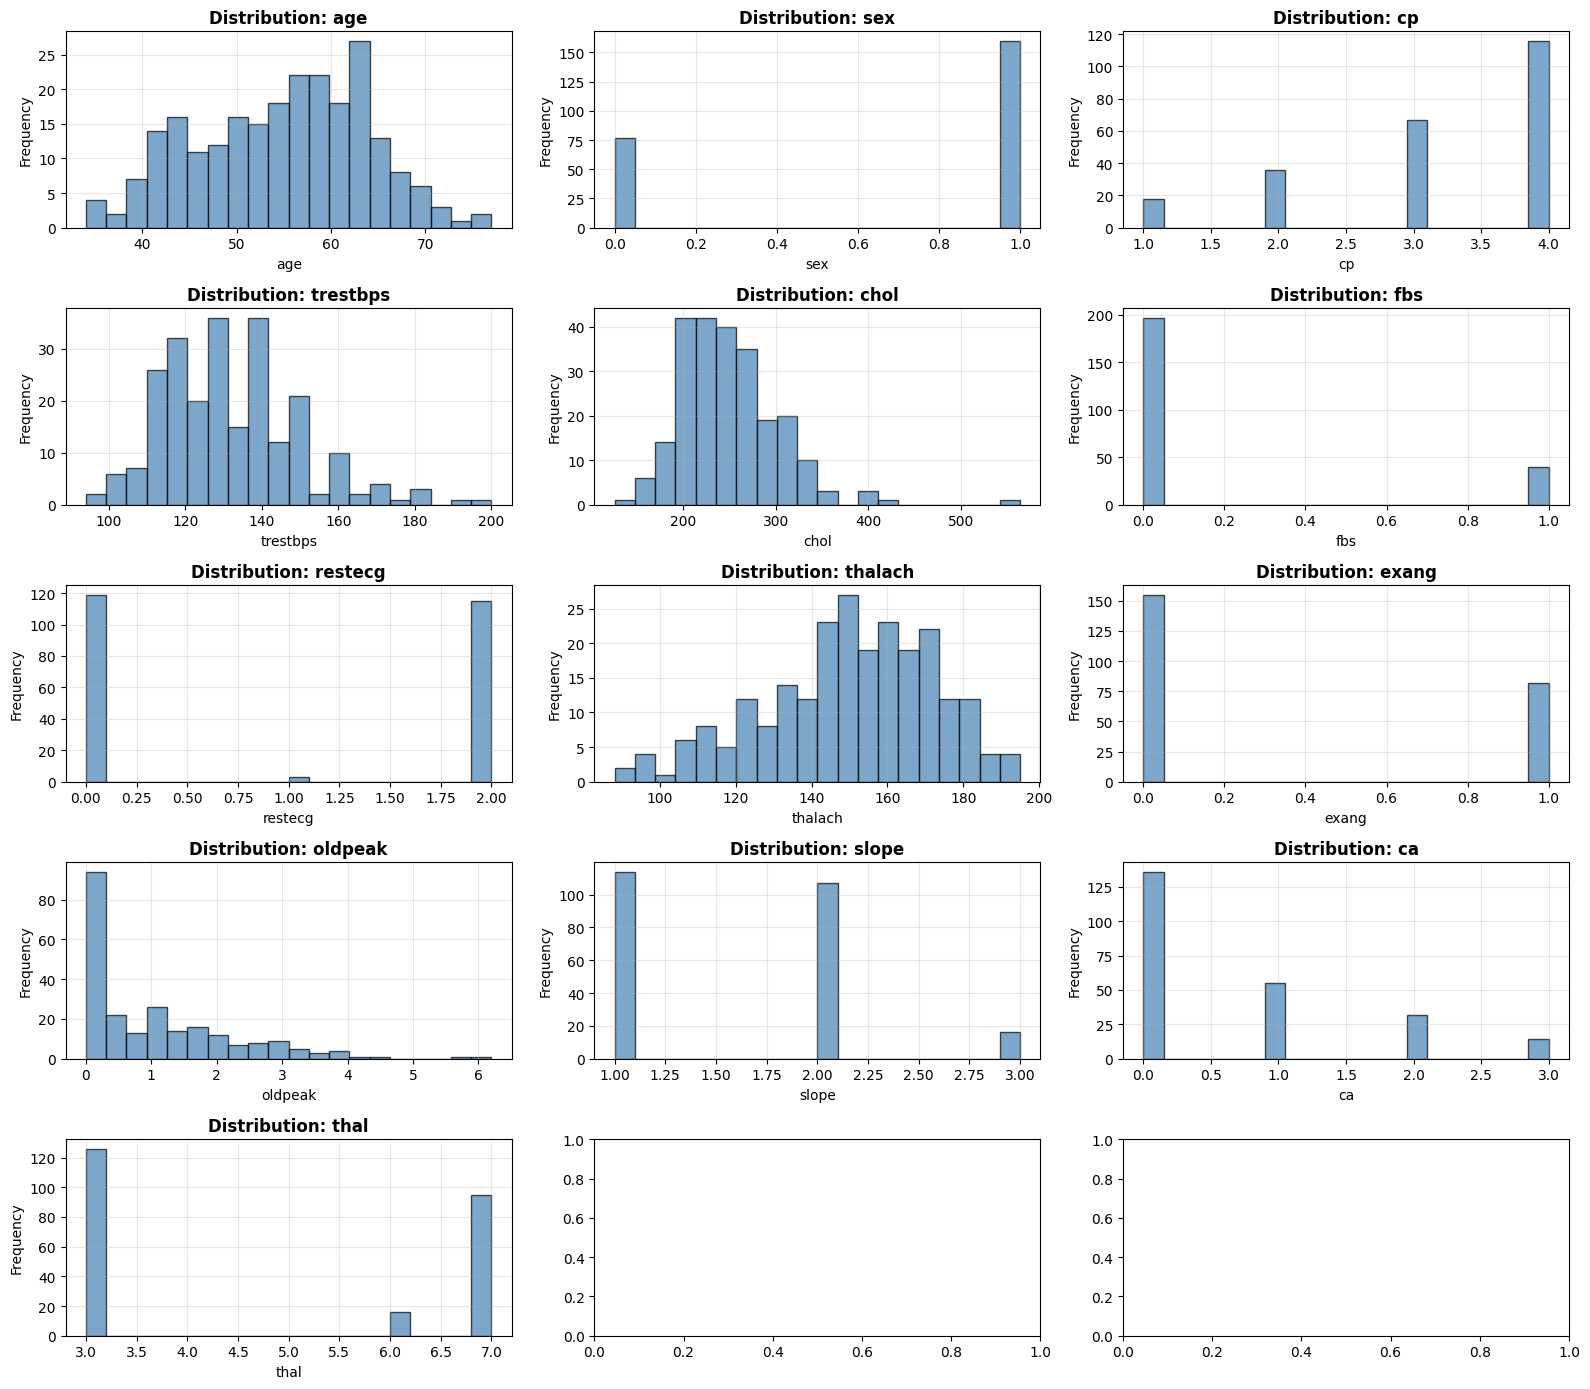


CLASSICAL MODEL SUMMARY
Model Type: Logistic Regression
Best C: 0.001
Penalty Type: l2

Test Set Performance:
  Accuracy:  0.9000
  Precision: 0.9231
  Recall:    0.8571
  F1-Score:  0.8889
  ROC-AUC:   0.9509

Confusion Matrix: TN=30, FP=2, FN=4, TP=24


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, confusion_matrix,
                             roc_auc_score)
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. LOAD AND EXPLORE DATASET
# ============================================================================
print("Loading Heart Disease dataset...")
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

# Flatten target to 1D array
y = y.values.ravel()

print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:\n{pd.Series(y).value_counts().sort_index()}")
print(f"\nFeatures:\n{X.columns.tolist()}")

# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values (if any)
print(f"Missing values per feature:\n{X.isnull().sum()}")
X = X.dropna()
y = y[X.index]
print(f"Dataset shape after dropping NaN: {X.shape}")

# Convert target to binary (presence vs. absence of disease)
# 0 = no disease, 1+ = disease present
y_binary = (y > 0).astype(int)
print(f"\nBinary target distribution:\n{pd.Series(y_binary).value_counts()}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize features (critical for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features standardized using StandardScaler")

# ============================================================================
# 3. HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

# Test different regularization strengths and penalty types
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalty_types = ['l1', 'l2']
results = []

for penalty in penalty_types:
    for C in C_values:
        try:
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear',
                                   max_iter=1000, random_state=42)
            lr.fit(X_train_scaled, y_train)
            y_pred = lr.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            results.append({'C': C, 'Penalty': penalty, 'Accuracy': accuracy})
            print(f"C={C:7.3f}, Penalty={penalty:2s}: Test Accuracy = {accuracy:.4f}")
        except:
            pass

# Find best hyperparameters
best_result = max(results, key=lambda x: x['Accuracy'])
best_C = best_result['C']
best_penalty = best_result['Penalty']
print(f"\nBest hyperparameters: C={best_C}, Penalty={best_penalty}")

# ============================================================================
# 4. TRAIN FINAL MODEL
# ============================================================================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

model = LogisticRegression(C=best_C, penalty=best_penalty, solver='liblinear',
                          max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
print(f"Model trained with C={best_C}, Penalty={best_penalty}")

# ============================================================================
# 5. EVALUATION METRICS
# ============================================================================
print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# ============================================================================
# 6. CONFUSION MATRIX
# ============================================================================
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")

# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[0, 0].set_title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve - Logistic Regression', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
axes[1, 0].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Performance Metrics - Logistic Regression', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1.05])
for i, v in enumerate(metrics_values):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['Coefficient'].values,
                color=['green' if x > 0 else 'red' for x in feature_importance['Coefficient'].values],
                alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['Feature'].values)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('logistic_regression_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'logistic_regression_results.png'")
plt.show()

# ============================================================================
# 8. FEATURE CORRELATION HEATMAP
# ============================================================================
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("Feature correlation heatmap saved as 'feature_correlation_heatmap.png'")
plt.show()

# ============================================================================
# 9. FEATURE DISTRIBUTIONS
# ============================================================================
fig, axes = plt.subplots(5, 3, figsize=(16, 14))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].hist(X_train[col], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Distribution: {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
print("Feature distributions saved as 'feature_distributions.png'")
plt.show()

# ============================================================================
# 10. SUMMARY
# ============================================================================
print("\n" + "="*70)
print("CLASSICAL MODEL SUMMARY")
print("="*70)
print(f"Model Type: Logistic Regression")
print(f"Best C: {best_C}")
print(f"Penalty Type: {best_penalty}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"\nConfusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")